In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.animation import FuncAnimation
from ipywidgets import IntProgress
from IPython.display import display, HTML

import base
import fund_scanner.common_tools.database as db
engine = db.get_sqlalchemy_engine(dbname='stock_index')

import logging
import fund_scanner.common_tools.logger as logger
log = logging.getLogger('view_indexes')


In [2]:
df = pd.read_sql('select * from stock_indexes where `发布日期` between "2017-08-05" and Now();', engine)
df_to_plot = pd.DataFrame([])
for code in df['index_code'].unique():
    df_one_kind = df.loc[df['index_code']==code, ['序号','行业','行业指数','涨跌幅','发布日期','index_code']]
    df_one_kind = df_one_kind.reset_index().set_index('发布日期')
    
    industry_name = df_one_kind['行业'].iloc[0]
    first_number = df_one_kind['行业指数'].iloc[0]
    df_to_plot[industry_name] = df_one_kind['行业指数'] / first_number * 100

df_to_plot = df_to_plot.sort_values(by=df_to_plot.last_valid_index(), axis=1, ascending=False)
display(df_to_plot)

,有色冶炼加工,新材料,煤炭开采,钢铁,饮料制造,养殖业,农产品加工,生物制品,食品加工制造,医疗器械服务,...,基础化学,视听器材,包装印刷,非汽车交运,保险及其他,机场航运,公路铁路运输,证券,国防军工,银行
发布日期,,,,,,,,,,,,,,,,,,,,,
2017-08-05,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,...,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000
2017-08-07,103.472636,102.897005,102.472566,105.378919,102.621760,100.166322,101.066088,102.063029,100.480628,100.813111,...,100.400396,100.446855,100.294971,100.433004,99.678457,99.781939,99.779462,99.500381,98.764686,99.879325
2017-08-08,104.452526,103.830557,100.949508,103.026938,102.089199,105.273911,104.256309,102.478587,100.973249,101.525741,...,99.848414,100.175133,100.158430,100.670457,100.522223,99.772167,99.968219,100.447665,99.322570,99.671967
2017-08-09,106.820169,106.390810,106.361436,105.875270,104.692014,103.703890,103.455606,102.869748,102.630111,102.443683,...,99.980834,99.977710,99.974290,99.861776,99.786941,99.752110,99.312384,98.871942,98.553075,98.256155


In [3]:
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
df_to_tsne = df_to_plot.T

#display(df_to_tsne)
model = TSNE(n_components=2, learning_rate=10)
df_result = pd.DataFrame(model.fit_transform(df_to_tsne))
df_result.columns = ['pos_x', 'pos_y']
df_to_tsne = df_to_tsne.reset_index()
df_result = pd.concat([df_to_tsne, df_result], axis=1)
#display(df_result)

df_pos = df_result.set_index('index').loc[:,['pos_x', 'pos_y']].T
display(df_pos)


index,有色冶炼加工,新材料,煤炭开采,钢铁,饮料制造,养殖业,农产品加工,生物制品,食品加工制造,医疗器械服务,...,基础化学,视听器材,包装印刷,非汽车交运,保险及其他,机场航运,公路铁路运输,证券,国防军工,银行
pos_x,1.620883,1.548682,1.202150,1.539280,1.160813,2.073368,1.915560,0.903018,-0.599803,0.005965,...,-0.056260,-0.419147,-0.399230,-0.928569,-0.834821,-0.261312,-0.521872,-0.769089,-0.609769,-0.622150
pos_y,4.284352,4.242104,4.277527,4.359565,4.051104,2.913382,2.970099,3.250323,2.595594,2.629105,...,-3.436966,-3.213805,-3.301816,-3.045997,-3.722177,-3.934884,-4.140073,-4.371721,-4.689507,-4.608959


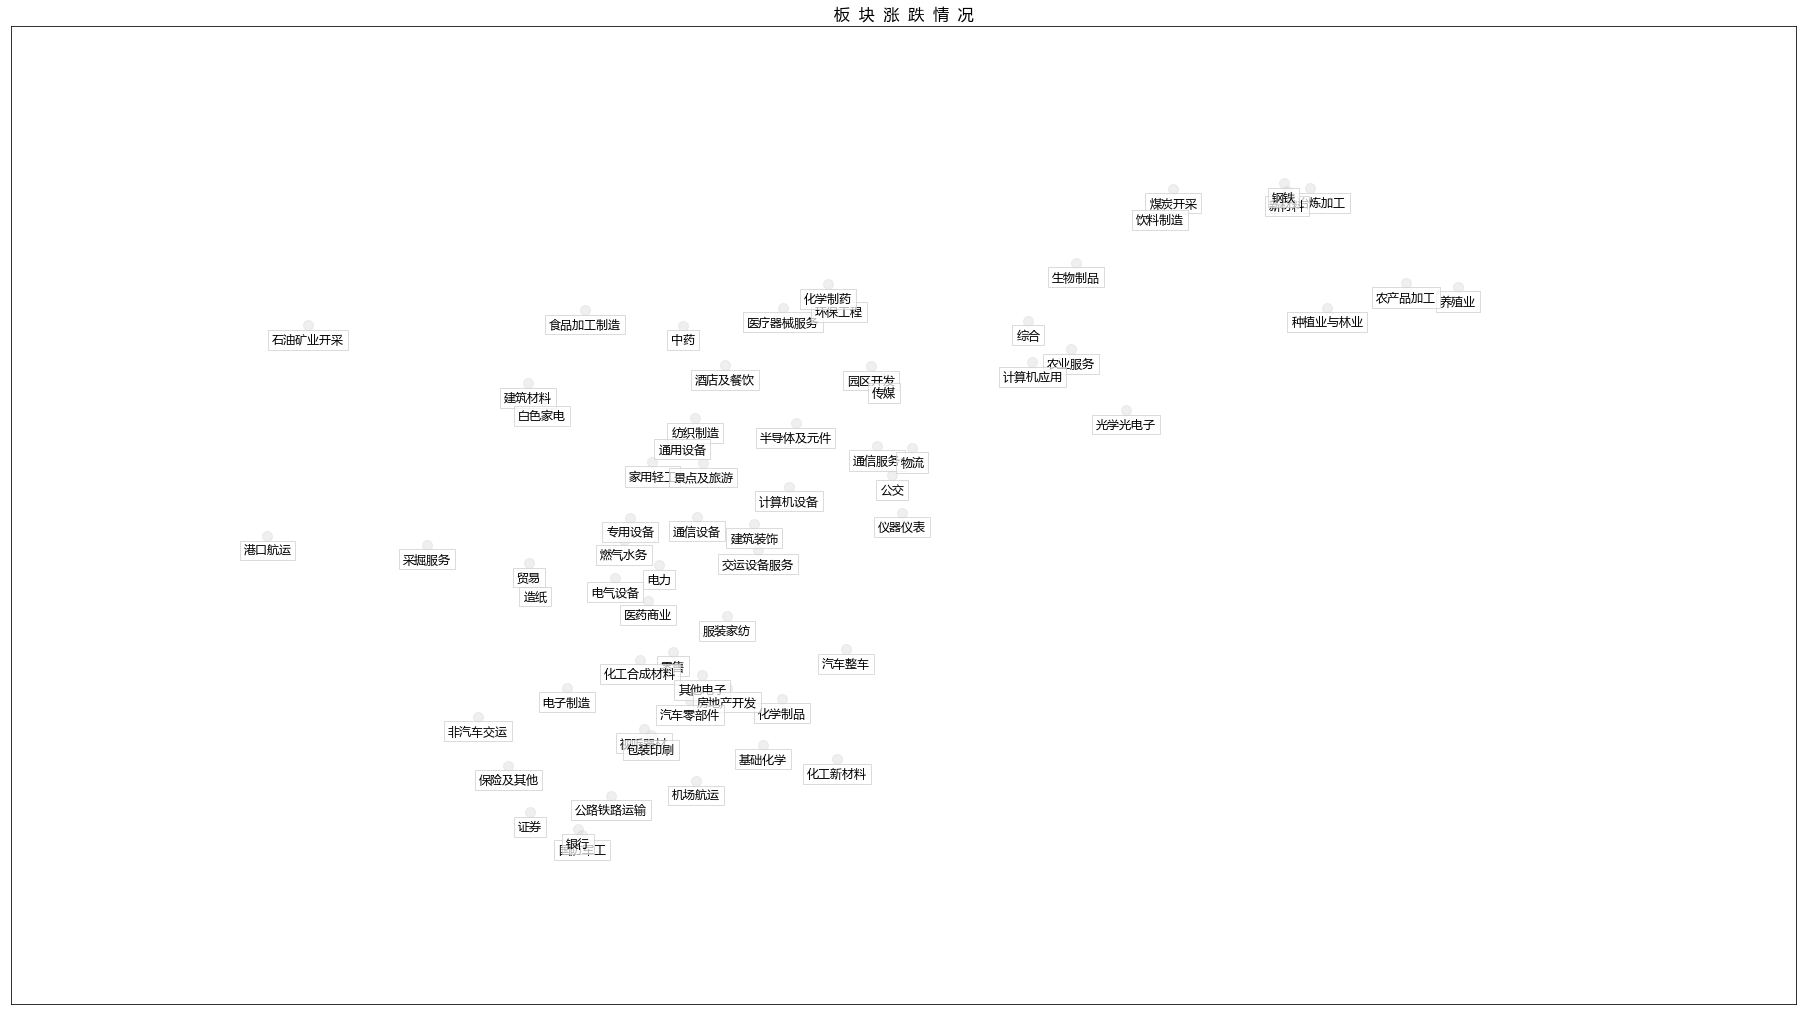

In [4]:
pos_type = 'tsne' # 'tsne' or 'matrix'

lst_industry_names = df_to_plot.columns.tolist()


items_each_row = 11
bubble_size_max = 1e4
bubble_size_middle = 1e2
bubble_size_min = 10
subtitle_offset_x = 0
subtitle_offset_y = -0.2
title_prefix = u'板 块 涨 跌 情 况'

fig = plt.figure(figsize=[32,18])
ax = fig.gca()
ax.set_xticks([])
ax.set_yticks([])
element_date = ax.set_title(title_prefix, fontsize=16)

if pos_type=='matrix':
    ax.set_xlim(0, items_each_row+1)
    ax.set_ylim(len(lst_industry_names) // items_each_row + 1, 0)
elif pos_type=='tsne':
    ax.set_xlim(df_pos.loc['pos_x', :].min()*1.5, df_pos.loc['pos_x', :].max()*1.5)
    ax.set_ylim(df_pos.loc['pos_y', :].min()*1.5, df_pos.loc['pos_y', :].max()*1.5)

i=0
element_scat = []
element_text = []
for industry_name in lst_industry_names:
    if pos_type=='matrix':
        pos_x = i % items_each_row + 1
        pos_y = i // items_each_row + 1
    elif pos_type=='tsne':
        pos_x = df_pos.loc['pos_x', industry_name]
        pos_y = df_pos.loc['pos_y', industry_name]
    
    scat = ax.scatter(pos_x, pos_y, s=bubble_size_middle, facecolor=(0.8,0.8,0.8,1), alpha=0.3)
    text = ax.text(pos_x+subtitle_offset_x, pos_y+subtitle_offset_y, industry_name, fontsize=12, 
                   horizontalalignment='center', verticalalignment='center',
                   bbox=dict(facecolor='white', edgecolor=(0.8,0.8,0.8,1), alpha=0.7))
    element_scat.append(scat)
    element_text.append(text)
    i=i+1



In [5]:
frames_per_day = 10
g_max = df_to_plot.max().max()
g_min = df_to_plot.min().min()
target_size = [bubble_size_middle] * len(element_scat)
last_size = [bubble_size_middle] * len(element_scat)

progress = IntProgress(min=0, max=(len(df_to_plot)+1)*frames_per_day-1, value=0)
display(progress)

def update(frame):
    global target_size, last_size, progress, frames_per_day, df_to_plot
    global element_date, element_scat, element_text
    progress.value = frame
    if progress.max <= frame:
        progress.bar_style = 'success'
    row = frame // frames_per_day
    last = frame % frames_per_day
    #print(row, last, len(df_to_plot))
    if (row<len(df_to_plot)):
        for idx, scat in enumerate(element_scat):
            if last==0:
                element_date.set_text(title_prefix + df_to_plot.iloc[row].name.strftime('%Y年 %m月 %d日 星期%w'))
                last_size[idx] = target_size[idx]
                val = df_to_plot.iloc[row, idx]
                target_size[idx] = (val - g_min) * (bubble_size_max-bubble_size_min) / (g_max - g_min) + bubble_size_min
                if target_size[idx]>last_size[idx]:
                    scat.set_facecolors(['red'])
                elif target_size[idx]<last_size[idx]:
                    scat.set_facecolors(['green'])
                else:
                    scat.set_facecolors([(0.8,0.8,0.8,1)])
                #if (idx==1):
                    #print('last_size:',last_size[idx],'target_size:',target_size[idx])
            size = (target_size[idx] - last_size[idx]) * last / frames_per_day + last_size[idx]
            
            scat.set_sizes([size])
        return element_scat
    return

animation = FuncAnimation(fig, update, interval=100, blit=False, frames=(len(df_to_plot)+1)*frames_per_day)
display(HTML(animation.to_html5_video()))
progress.close()


In [6]:
animation.save('../tmp/3days.gif', writer='imagemagick', fps=30, dpi=40)